# **Simulateur de méta-population : Analyse de sensibilité pour 2 espèces**

In [1]:
# Importation des librairies
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from multiprocess import Pool
import pickle

## Variables globales

In [2]:
N_ITER_SITE = 2  # Nombre de planning différents
NITER = 30  # Nombre d'itérations par planning
T = 100  # Nombre de pas de temps
X = 100  # Nombre de sites
E = 2  # Nombre d'espèces
H = 2  # Nombre de ressources

PALL = 0.05  # probabilité d'allumage d'un site éteint au temps t
PEXT = 0.05  # probilité d'extinction d'un site allumé au temps t

VALUE = np.linspace(0,2,5)

In [3]:
RES_X = [0]*math.ceil(X/2)+[1]*int(X/2)

In [8]:
liste_dispo = []
for s in range(N_ITER_SITE) :
    states = [random.randint(0,1) for i in range(X)]  # état initial des sites
    dispo = [states]
    for gen in range(T-1) :
        state = np.array(alea(dispo[gen])).T
        while np.mean(state) < 0.45 or np.mean(state) > 0.55 :
            state = np.array(alea(dispo[gen])).T
        dispo = dispo + [state]
    liste_dispo = liste_dispo + [dispo]
LISTE_DISPO = liste_dispo

In [9]:
np.mean(state)

0.46

In [10]:
# Variables liées aux espèces
# Génération des effectifs initiaux
N0X = [1]

R = [2]  # Taux de croissance maximal
MU = [0.1]  # Taux de mortalité
D = [0.1]  # Taux de dispersion
C = [0.5]  # Taux de mortalité lors de la dispersion

# Variables liées à l'exploitation des ressources (E = 3, H = 2)
K0 = [200]
SP = [0]
GE = list(np.linspace(0.5,0.9,3))

csts = [N0X,R,MU,D,C,GE,SP,K0]

test = list(itertools.product(*csts))

In [11]:
test

[(1, 2, 0.1, 0.1, 0.5, 0.5, 0, 200),
 (1, 2, 0.1, 0.1, 0.5, 0.7, 0, 200),
 (1, 2, 0.1, 0.1, 0.5, 0.9, 0, 200)]

In [12]:
if __name__ == '__main__':
    with Pool(4) as p:
        results = p.map(scenario, test)

In [5]:
def scenario(cst) :
    """ Fonction de calcul des dynamiques selon plusieurs interactions interspécifiques d'une méta-population 
    pour un set de paramètres pour NITER répétitions

    Paramètres
    ----------
    cst : list
        list des paramètres N0X, R, MU, D, C, GE, SP et K0
    
    Return
    ------
    array
    
    """
    n0 = np.array([[cst[0]]*E]*X)
    r = [cst[1]]*E  # Taux de croissance maximal
    mu = [cst[2]]*E  # Taux de mortalité
    d = [cst[3]]*E  # Taux de dispersion
    c = [cst[4]]*E  # Taux de mortalité lors de la dispersion

    # Variables liées à l'exploitation des ressources (E = 3, H = 2)
    res_exp = np.array([[cst[5], cst[6]],[cst[5], 1]])
    k_res = np.array([[cst[7]]*E]*H) * res_exp  # Capacité d'accueil des ressources
    k = [k_res[RES_X[x]] for x in range(X)]  # Capacité d'accueil du site pour chaque espèce
    const = [n0,r,mu,d,c,k]
    results = modif_interaction(VALUE, const)
    return([results,cst])

    

In [6]:
def alea(v) :
    """ Fonction de sélection aléatoire des sites disponibles au temps t+1
    
    Paramètres
    ----------
    v : list
        Statut des sites au temps t (0 ou 1)
    
    Return
    ------
    list
        Statut des sites au temps t+1 (0 ou 1)
    
    """

    all_t = [i for i in range(len(v)) if v[i]==1]
    ext_t = [i for i in range(len(v)) if v[i]==0]

    all_tplus = random.sample(ext_t, np.random.binomial(len(ext_t), PALL))
    ext_tplus = random.sample(all_t, np.random.binomial(len(all_t), PEXT))

    for i in all_tplus :
        v[i] = 1
    for i in ext_tplus :
        v[i] = 0
    
    return v

def interaction(n, a, i) :
    """ Fonction d'interaction d'une espèce i parmi R espèces

    Cette fonction calcule le membre 'somme(alpha_{ij}*N_j)' de l'équation de compétition de Lotka-Volterra pour l'espèce i

    Paramètres
    ----------
    n : liste de taille R
        Effectifs des R espèces
    a : array de taille R*R
        Matrice des coefficients d'interaction entre les R espèces
    i : int
        Identifiant de l'espèce d'intérêt
    
    Return
    ------
    float
        somme(alpha_{ij}*N_j)
    
    """
    alpha = a[i]  # Sélection des coefficients d'interaction de l'espèce i avec les R espèces
    inter = n*alpha  # alpha_{ij}*N_j
    return sum(inter)
def reproduction(n, a, i, x, c) :
    """ Fonction de croissance d'une espèce en compétition avec d'autres sur une génération

    Cette fonction calcule l'effectif après reproduction d'une population suivant une croissance logistique, en compétition
    de Lotka-Volterra avec d'autres espèces

    Paramètres
    ----------
    n : list
        Effectif des espèces au temps t
    i : int
        Identifiant de l'espèce d'intérêt
    
    Return
    ------
    int
        Effectif de la population après reproduction et mortalité au temps t
    
    """
    n = list(n[x])
    if c[5][x][i]==0 :
        return 0
    else :
        return int((n[i] + n[i]*c[1][i]*(1-(interaction(n, a, i)/c[5][x][i])))*(1-c[2][i]))
def dynamique_intra(n, x, a, c) :
    """ Fonction de dynamique de R espèces sur une génération à l'intérieur d'un site x

    Cette fonction calcule l'effectif à la génération suivante pour R espèces suivant une croissance logistique
    sur un site x, avec de la dispersion entre les X sites

    Paramètres
    ----------
    n : int
        Effectif de la population au temps t au site x
    x : int
        Identifiant du site x
    
    Return
    ------
    array de taille 2
        Effectif de chaque espèce après reproduction et dispersion, et nombre de migrants issus du site x
    
    """
    nb = np.array([reproduction(n, a, i, x, c) for i in range(E)])  # Effectif après reproduction
    nb[nb < 0] = 0
    d = np.array([int(c[3][i]*nb[i]) for i in range(E)])

    return [nb-d,d]
def effectif(n) : 
    """ Fonction de tri des effectif des espèces

    Cette fonction traite les données issues de la fonction dynamique_intra et regroupe d'une part les effectifs de 
    chaque espèce dans chaque site dans une matrice R*X, et d'autre part les pools de migrant de chaque espèce dans une liste

    Paramètres
    ----------
    n : array de taille X*R*2
        Effectif de chaque espèces et migrants issus de chaque site
    
    Return
    ------
    list(array, list)
        Liste avec la matrice des effectifs de chaque espèce dans chaque site, et la liste des pools de migrant de chaque espèce
    
    """
    site = np.array([n[x][0] for x in range(X)])
    pool = np.array([n[x][1] for x in range(X)])
    pool = list(np.sum(pool,0))
    return list([site, pool])
def migration(m, i, c) :
    """ Fonction de migration d'une espèce i entre X sites

    Cette fonction répartit selon une distribution multinomiale un pool de migrants entre X sites

    Paramètres
    ----------
    m : int
        Pool de migrants
    
    Return
    ------
    list
        Effectifs de migrants dans chacun des sites
    
    """
    m = m[i] - int(m[i]*c[4][i])  # Application du taux de mortalité pendant la dispersion
    return np.random.multinomial(m, [1/X]*X)
def dynamique_inter(n, a, c) :
    """ Fonction de dynamique d'une population sur une génération entre plusieurs sites

    Cette fonction calcule l'effectif à la génération suivante d'une population suivant une croissance logistique
    sur plusieurs sites, avec de la dispersion entre les sites

    Paramètres
    ----------
    n : list
        Effectif de la population sur chaque site au temps t
    
    Return
    ------
    array de taille 2
        Effectif de la population après reproduction et dispersion dans chaque site, et nombre de migrants de chaque espèce
    
    """
    intra = np.array([dynamique_intra(n, x, a, c) for x in range(X)])  # Calcul des effectifs et des migrants de chaque site
    eff = effectif(intra)  # Tri des effectifs
    d = eff[1]  # Sélection des pools de migrants
    mig = np.array([migration(d,i,c) for i in range(E)]).T  # Répartition des migrants entre les sites
    n_plus = eff[0]+ mig  # Effectifs de chaque espèce dans chaque site à la fin de la génération
    return [n_plus, d]


def visualisation_mean_pop_totale(n, value) :
    """ Fonction de visualisation de la dynamique de la population totale moyenne pour un set de paramètre sur N_ITER répétitions
    
    Paramètres
    ----------
    n : array
        Array des effectifs totaux moyens aux T pas de temps pour N_ITER répétitions
    
    Return
    ------
    figure
    
    """
    palette = sns.color_palette(None, H+E)
    f = math.ceil(math.sqrt(len(value)))  # Taille de la figure : f*f
    fig1 = plt.figure(1, figsize=(20,15))
    fig2 = plt.figure(2, figsize=(20,15))
    ref = np.mean(n[0], axis = 0)
    for val in range(len(value)) :
        mean = np.mean(n[val], axis = 0)
        rel = np.divide(mean, ref)
        sd = np.std(n[val], axis = 0)
        min_tot = np.amin(n[val], axis = 0)
        max_tot = np.amax(n[val], axis = 0)
        ci95 = 1.96 * sd/np.sqrt(NITER)
        a = mean-ci95
        a[a < 0] = 0
        b = mean+ci95
        b[b > X*K0] = X*K0
        ax1 = fig1.add_subplot(f,f,val+1)
        ax1.set_title(value[val])
        ax2 = fig2.add_subplot(f,f,val+1)
        ax2.set_ylim([0, 1.1])
        ax2.set_title(value[val])
        for i in range(E):
            ax1.fill_between(range(T), min_tot[i], max_tot[i], color=palette[i], alpha=0.15)
            ax1.fill_between(range(T), a[i], b[i], color=palette[i], alpha=0.5)
            ax1.plot(mean[i], color = palette[i])
            ax2.plot(rel[i], color = palette[i])
        
    plt.show(fig1)
    plt.show(fig2)

def modif_interaction(value, c) :
    """ Fonction de modification d'une variable globale dans un intervalle de valeurs
    
    Paramètres
    ----------
    var : str
        Variable à modifier
    
    value : list
        Valeurs à tester
    
    Return
    ------
    figure
    
    """
    list_tot_pop_res1 = []
    list_tot_pop_res2 = []

    N0_res1 = np.array([c[0][i] for i in range(X) if RES_X[i]==0])
    N0_res2 = np.array([c[0][i] for i in range(X) if RES_X[i]==1])

    for val1 in range(len(value)) :
        for val2 in range(len(value)) :

            a = np.array([[1.0]*E]*E)
            a[0,1] = value[val1]
            a[1,0] = value[val2]

            list_tot_pop_iter_site_res1 = []
            list_tot_pop_iter_site_res2 = []


            for s in range(N_ITER_SITE) :

                list_iter_res1 = []
                list_iter_res2 = []

                for iter in range(NITER) :
                    list_n = [c[0]]
                    list_n_res1 = [N0_res1]  # Liste des effectifs de la population sur chaque site à chaque pas de temps
                    list_n_res2 = [N0_res2]

                    for gen in range(T-1) :
                        n_plus = dynamique_inter(list_n[gen],a,c)[0]
                        n_plus = np.array([n_plus.T[e]*LISTE_DISPO[s][gen] for e in range(E)])
                        n_plus = n_plus.T
                        n_plus_res1 = np.array([n_plus[i] for i in range(X) if RES_X[i]==0])
                        n_plus_res2 = np.array([n_plus[i] for i in range(X) if RES_X[i]==1])
                        
                        list_n_res1 = list_n_res1 + [n_plus_res1]
                        list_n_res2 = list_n_res2 + [n_plus_res2]
                        
                        list_n = list_n + [n_plus]

                    list_n_res1 = np.array(list_n_res1).T
                    list_n_res2 = np.array(list_n_res2).T
                    list_iter_res1 = list_iter_res1 + [list_n_res1]
                    list_iter_res2 = list_iter_res2 + [list_n_res2]

                list_iter_res1 = np.array(list_iter_res1)
                list_iter_res2 = np.array(list_iter_res2)

                pop_tot_iter_res1 = np.sum(list_iter_res1, axis = 2)
                pop_tot_iter_res2 = np.sum(list_iter_res2, axis = 2)

                list_tot_pop_iter_site_res1 = list_tot_pop_iter_site_res1 + [pop_tot_iter_res1]
                list_tot_pop_iter_site_res2 = list_tot_pop_iter_site_res2 + [pop_tot_iter_res2]

            list_tot_pop_res1 = list_tot_pop_res1 + [list_tot_pop_iter_site_res1]
            list_tot_pop_res2 = list_tot_pop_res2 + [list_tot_pop_iter_site_res2]

    return([np.array(list_tot_pop_res1), np.array(list_tot_pop_res2)])

In [60]:
def visualisation_param(n, value, dispo) :
    """ Fonction de visualisation de la dynamique de la population totale moyenne pour un set de paramètre sur N_ITER répétitions
    pour n_iter_site disponibilités différentes
    
    Paramètres
    ----------
    n : array
        Array des effectifs totaux moyens aux T pas de temps pour N_ITER répétitions pour n_iter_site disponibilités
    
    Return
    ------
    figure
    
    """
    dispo = np.array(dispo)
    mean_dispo = np.mean(dispo, axis = 0)
    disp_res1 = np.sum(np.array([np.array(mean_dispo).T[i] for i in range(X) if RES_X[i]==0]), axis=0)
    disp_res2 = np.sum(np.array([np.array(mean_dispo).T[i] for i in range(X) if RES_X[i]==1]), axis=0)

    time = [i for i in range(T)]

    palette = sns.color_palette(None, H+E)
    dominant = sns.diverging_palette(30, 250, l=65, center="dark", as_cmap=True)

    f =len(value)  # Taille de la figure : f*f
    fig1 = plt.figure(1, figsize=(20,15))
    fig1.suptitle("Dynamique globale")
    fig2 = plt.figure(2, figsize=(20,15))
    fig2.suptitle("Dynamique dans la ressource 1")
    fig3 = plt.figure(3, figsize=(20,15))
    fig3.suptitle("Dynamique dans la ressource 2")
    fig4 = plt.figure(4, figsize=(20,15))
    fig4.suptitle("Diversité exp(H) dans la ressource 2")
    fig5 = plt.figure(5, figsize=(20,15))
    fig5.suptitle("Espèce dominante dans la ressource 2")
    for val1 in range(len(value)) :
        for val2 in range(len(value)) :
            val = val1*len(value) + val2
            ax1 = fig1.add_subplot(f,f,val+1)
            ax1.set_title(value[val2])
            ax1.set_ylim([-100, K0[0]*X/3])
            ax2 = fig2.add_subplot(f,f,val+1)
            ax2.set_title(value[val2])
            ax2.set_ylim([-100, K0[0]*X/6])
            ax3 = fig3.add_subplot(f,f,val+1)
            ax3.set_title(value[val2])
            ax3.set_ylim([-100, K0[0]*X/6])
            ax4 = fig4.add_subplot(f,f,val+1)
            ax4.set_title(value[val2])
            ax4.set_ylim([0.9, 2.1])
            ax5 = fig5.add_subplot(f,f,val+1)
            ax5.set_title(value[val2])
            ax5.set_ylim([-1.1, 1.1])
            op = np.linspace(0.3,1,len(n))
            for param in range(len(n)) :
                n_res1 = n[param][0][0]
                n_res2 = n[param][0][1]
                n_tot = n_res1 + n_res2
                mean = np.mean(np.mean(n_tot[val], axis = 1), axis = 0)
                #sd = np.std(np.mean(n_tot[val], axis = 1), axis = 0)
                #ci95 = 1.96 * sd/np.sqrt(NITER)
                #a = mean-ci95
                #a[a < 0] = 0
                #b = mean+ci95
                #b[b > X*K0[0]] = X*K0[0]

                mean1 = np.mean(np.mean(n_res1[val], axis = 1), axis = 0)
                #sd1 = np.std(np.mean(n_res1[val], axis = 1), axis = 0)
                #ci951 = 1.96 * sd1/np.sqrt(NITER)
                #a1 = mean1-ci951
                #a1[a1 < 0] = 0
                #b1 = mean1+ci951
                #b1[b1 > X*K0[0]] = X*K0[0]

                mean2 = np.mean(np.mean(n_res2[val], axis = 1), axis = 0)
                #sd2 = np.std(np.mean(n_res2[val], axis = 1), axis = 0)
                #ci952 = 1.96 * sd2/np.sqrt(NITER)
                #a2 = mean2-ci952
                #a2[a1 < 0] = 0
                #b2 = mean2+ci952
                #b2[b2 > X*K0[0]] = X*K0[0]

                tot_mean = np.sum(mean2, axis = 0)
                p_tot = [np.divide(mean2[i],tot_mean) for i in range(E)]
                p_diff = p_tot[0] - p_tot[1]
                d = []
                esp = []
                for t in range(T) :
                    h = 0
                    for i in range(E) :
                        if p_tot[i][t]==0 :
                            h = h
                        else :
                            h = h - p_tot[i][t]*math.log(p_tot[i][t])
                    d = d + [math.exp(h)]
                    esp = esp +[p_diff[t]*math.exp(h)]
                d = np.array(d)
                esp = np.array(esp)
                
                
                for i in range(E):
                    #ax1.fill_between(range(T), a[i], b[i], color=palette[i], alpha=0.5)
                    ax1.plot(mean[i], color = palette[i], alpha = op[param], lw = 2)

                    #ax2.fill_between(range(T), a1[i], b1[i], color=palette[i], alpha=0.5)
                    ax2.plot(mean1[i], color = palette[i], alpha = op[param], lw = 2)

                    #ax3.fill_between(range(T), a2[i], b2[i], color=palette[i], alpha=0.5)
                    ax3.plot(mean2[i], color = palette[i], alpha = op[param], lw = 2)
   
                ax4.scatter(time, d, c=esp[time], vmin=-1, vmax=1, cmap=dominant, alpha = op[param], lw = 0.1)
                ax4.plot(d, color = "black", alpha = op[param], lw = 1)
                ax5.plot(esp, color = palette[0], alpha = op[param], lw = 2)
        
    plt.show(fig1)
    plt.show(fig2)
    plt.show(fig3)
    plt.show(fig4)

In [14]:
filehandler = open("test.npy","wb")
pickle.dump(results,filehandler)
filehandler.close()

In [ ]:
file = open("test.npy",'rb')
object_file = pickle.load(file)
file.close()

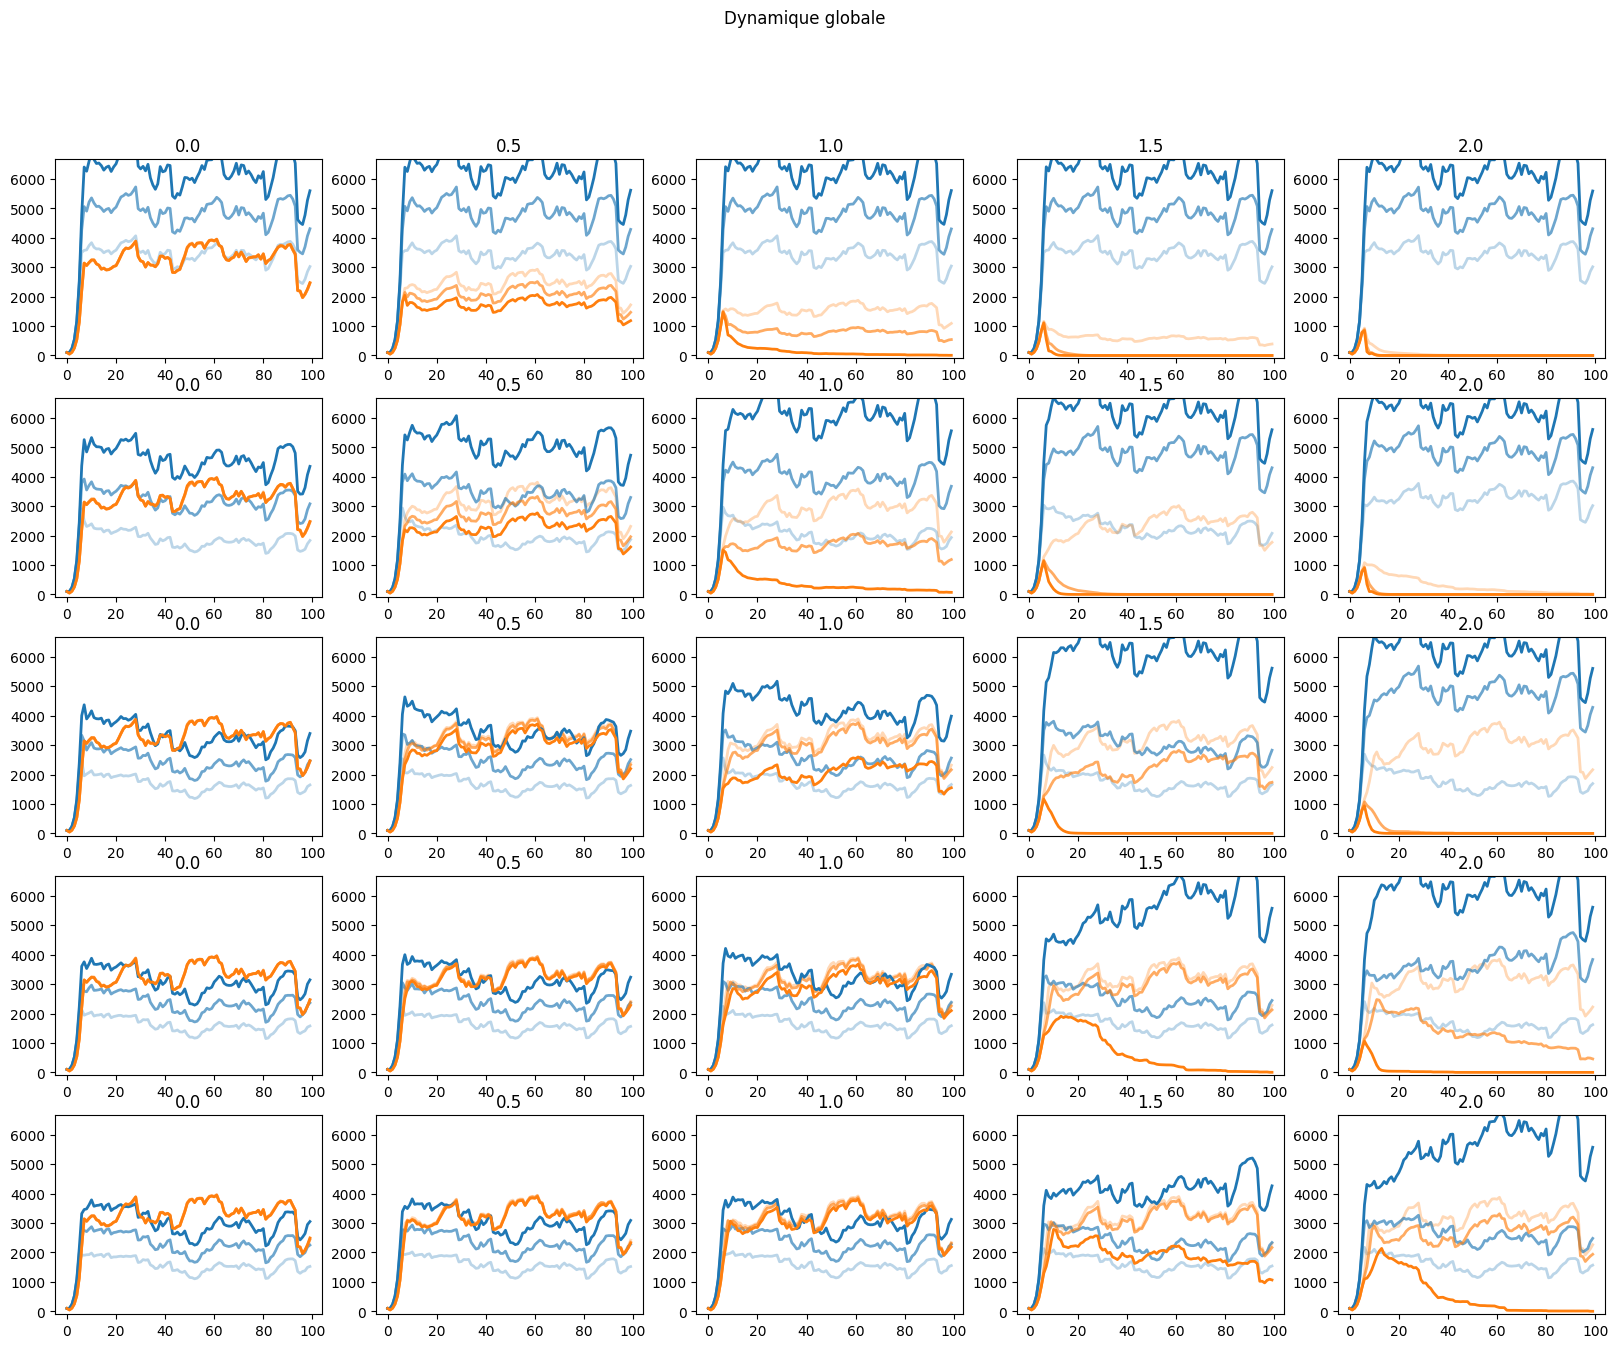

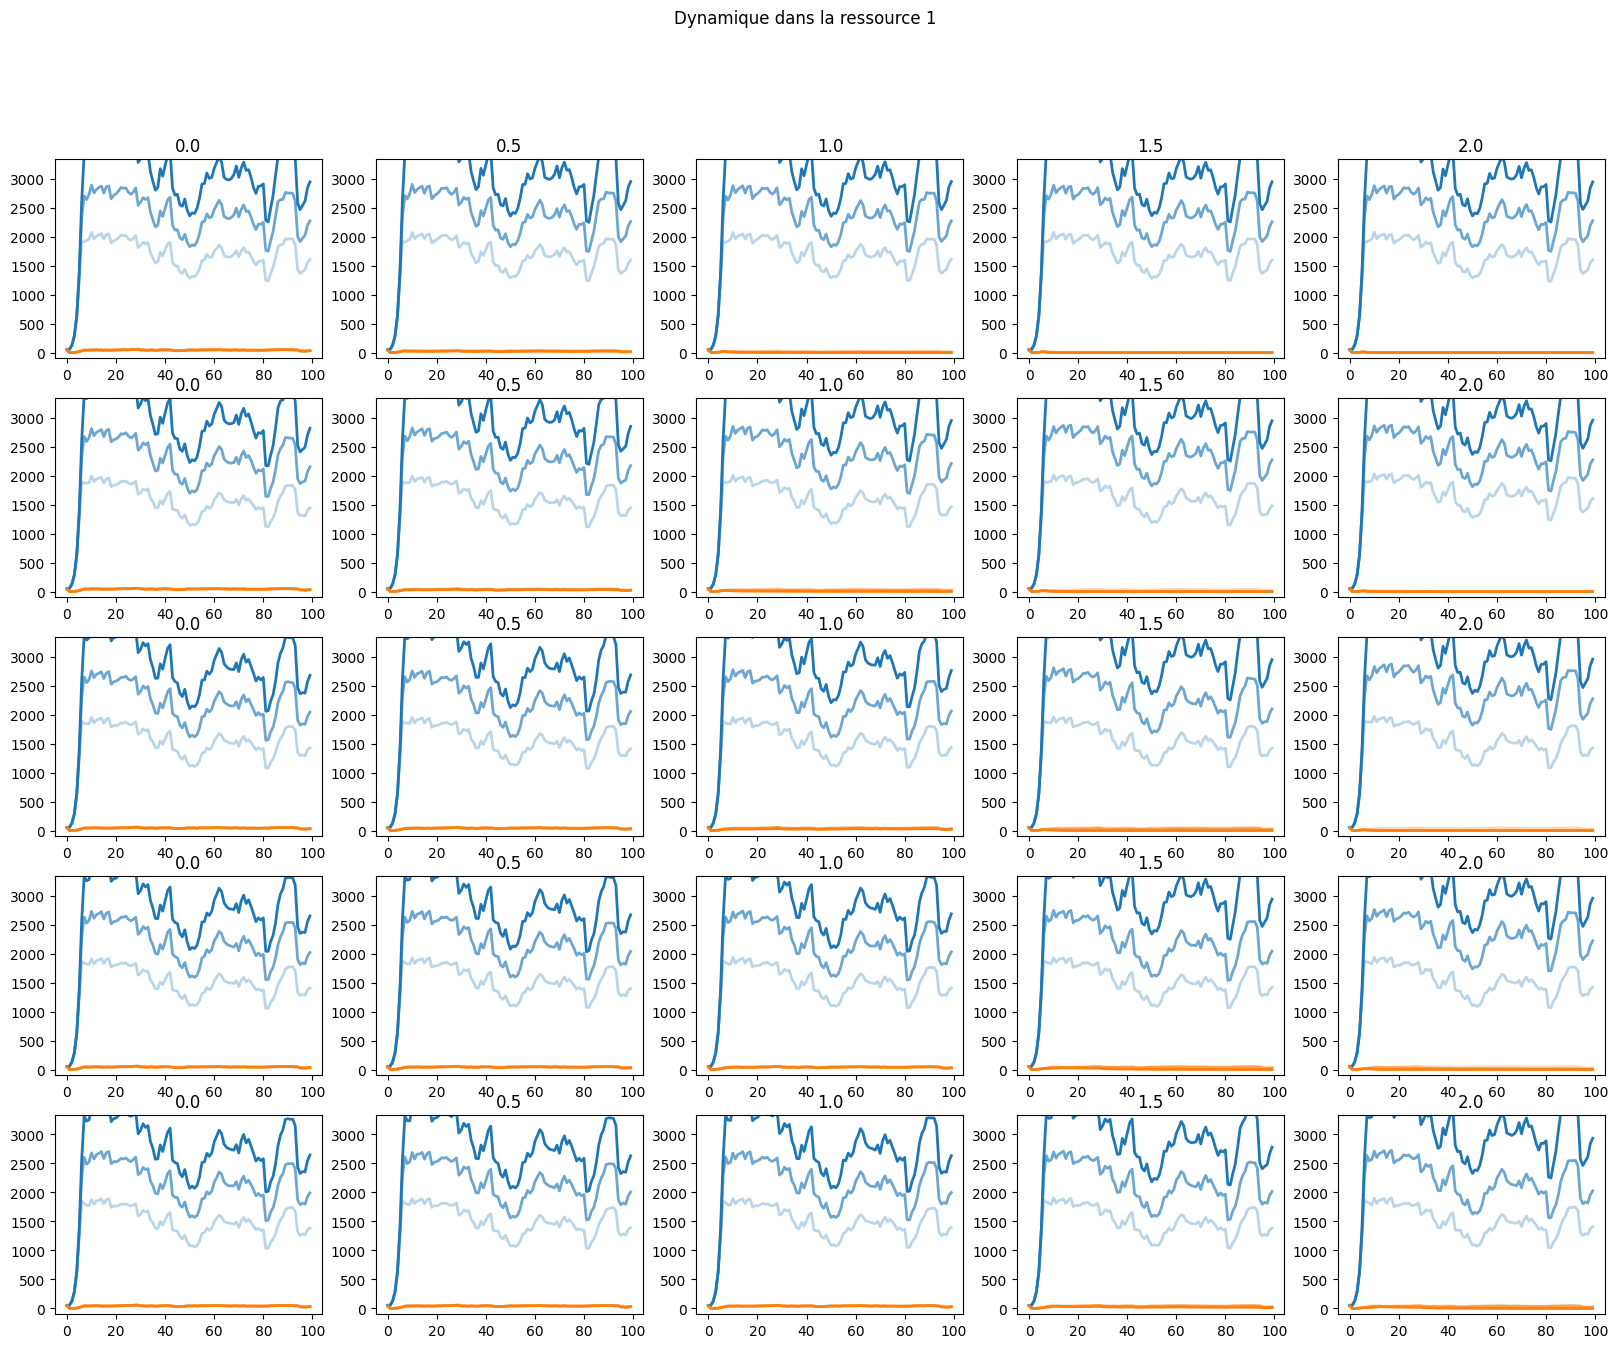

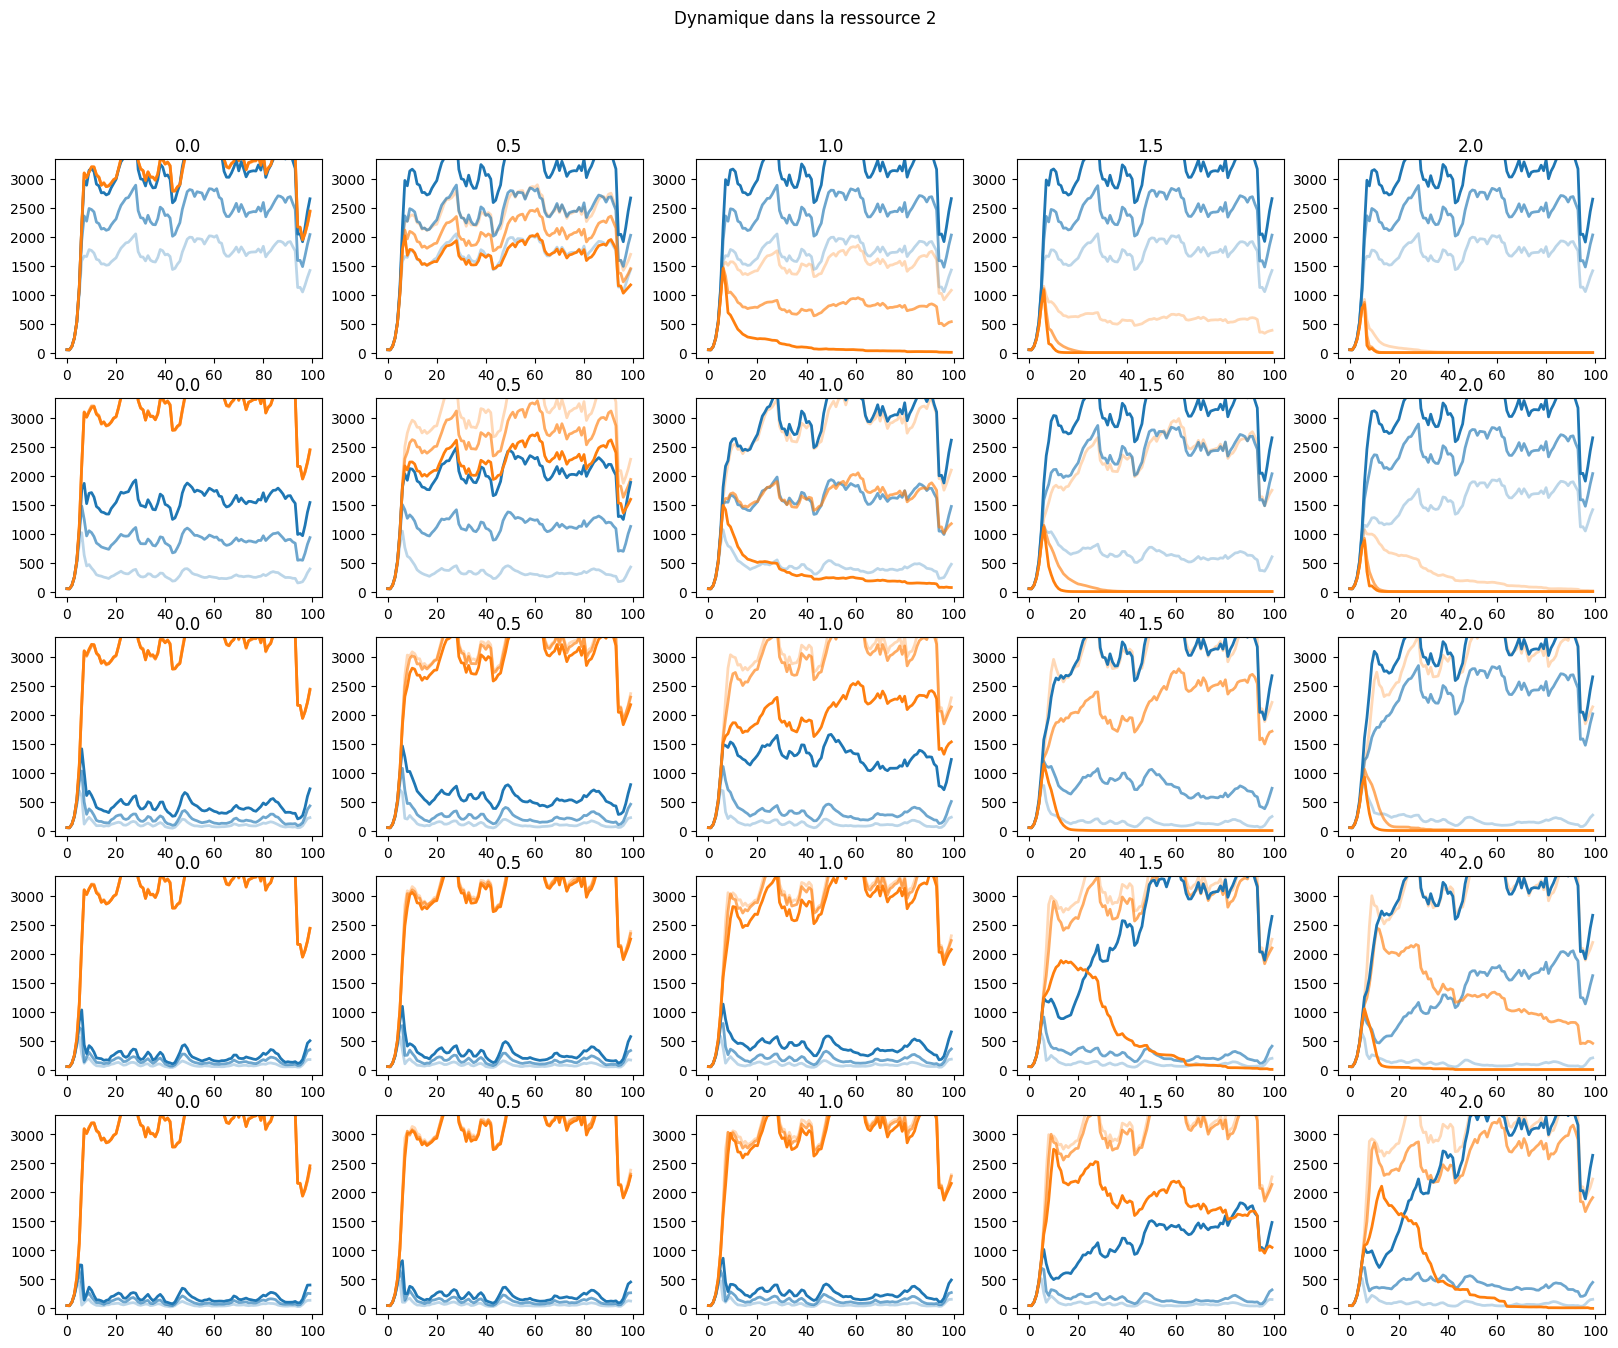

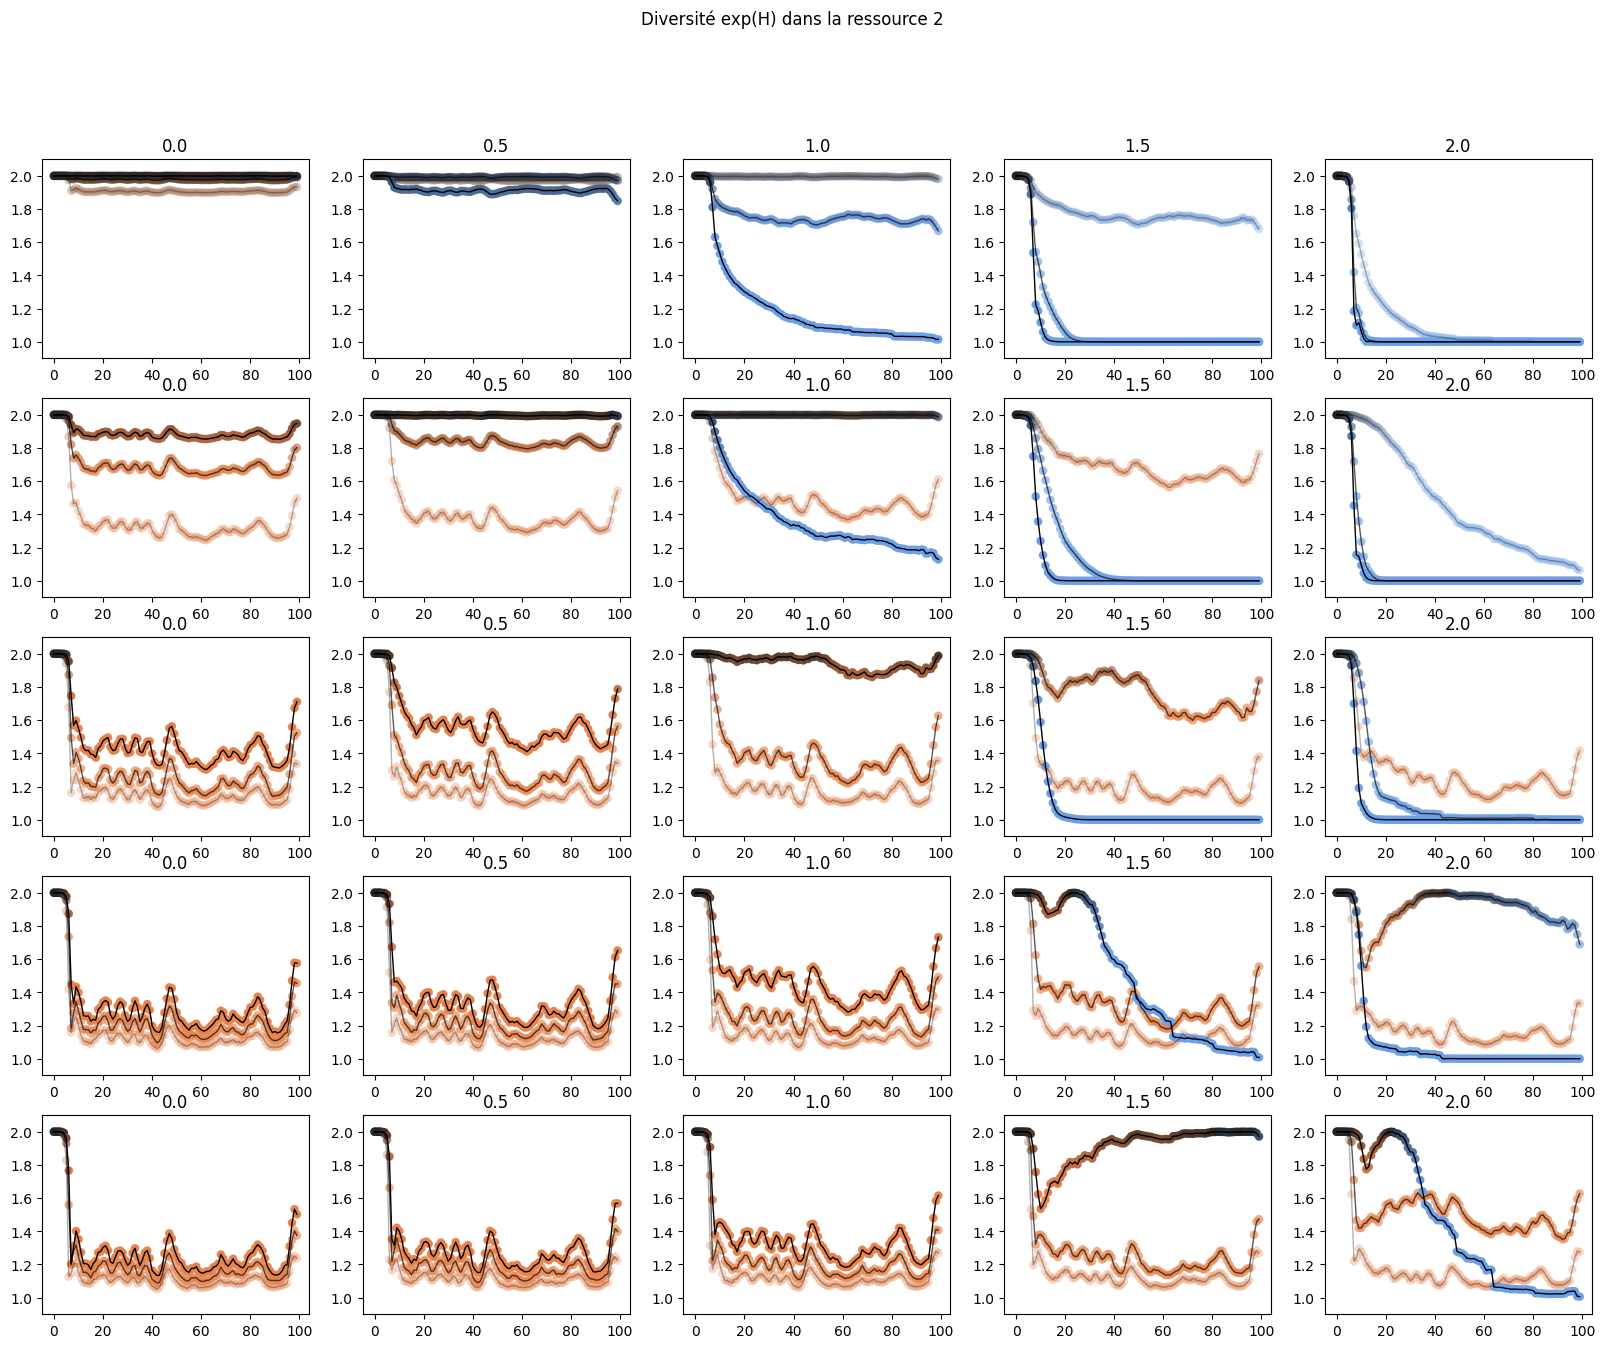

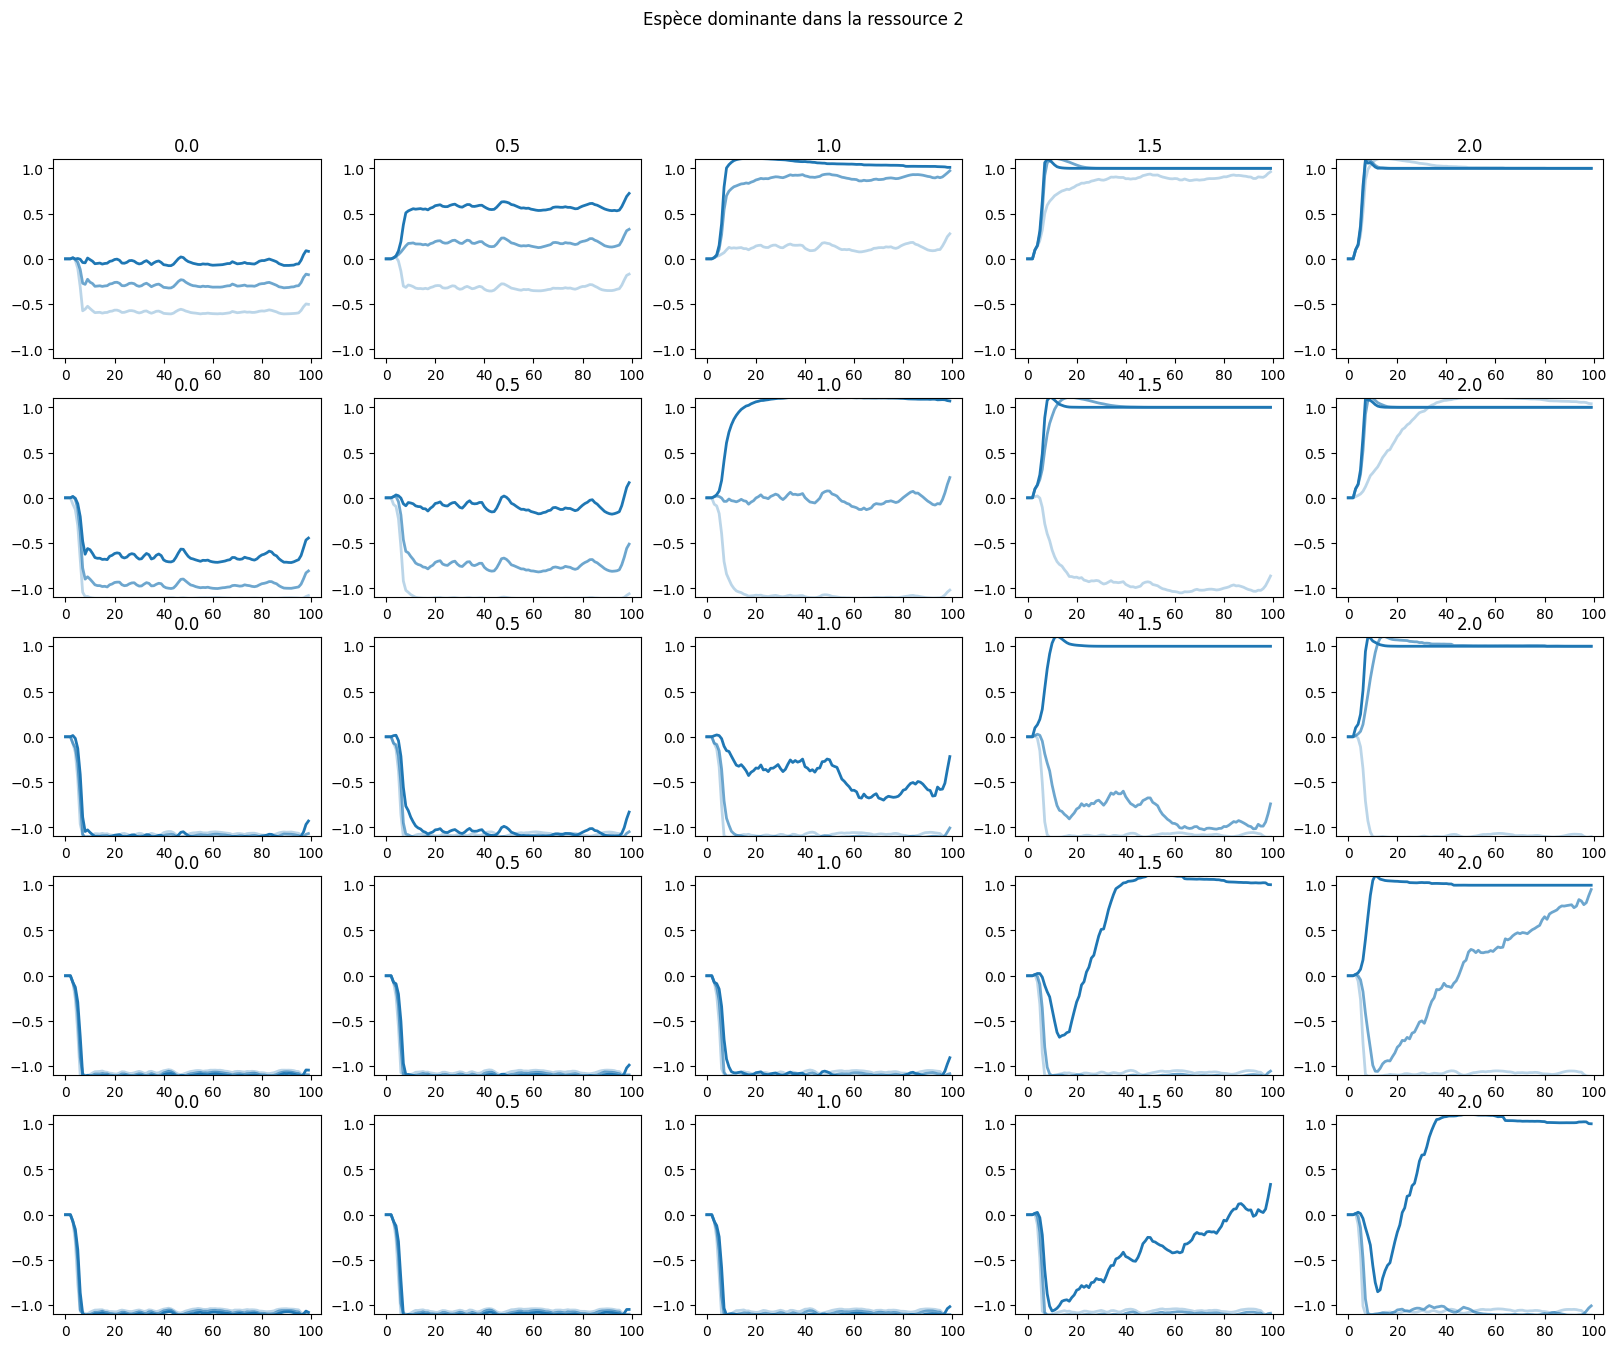

In [61]:
visualisation_param(results, VALUE, LISTE_DISPO)

In [10]:
dispo = np.array(LISTE_DISPO)
mean_dispo = np.mean(dispo, axis = 0)
disp_res1 = np.sum(np.array([np.array(mean_dispo).T[i] for i in range(X) if RES_X[i]==0]), axis=0)
disp_res2 = np.sum(np.array([np.array(mean_dispo).T[i] for i in range(X) if RES_X[i]==1]), axis=0)
disp_tot = np.sum(mean_dispo.T, axis=0)

In [11]:
print(disp_res1)
#disp_tot

[12.775 12.525 12.55  12.525 12.6   12.925 12.85  12.625 12.4   12.375
 12.475 12.8   12.7   12.55  12.975 12.825 12.925 12.7   12.75  12.75
 12.925 12.75  12.575 12.575 12.75  12.825 12.6   12.55  12.725 12.25
 12.225 12.45  12.725 12.625 12.575 12.4   12.7   12.875 12.85  12.8
 12.875 12.7   12.7   12.525 12.65  12.575 12.825 12.275 12.65  12.875
 12.075 12.325 12.425 12.475 12.25  12.325 12.55  12.375 12.275 12.275
 12.15  11.9   12.025 11.95  12.2   12.3   12.5   12.45  12.35  12.4
 12.475 12.725 12.35  12.575 12.325 12.625 12.4   12.35  12.25  12.3
 12.35  12.625 12.7   12.875 12.85  13.075 13.1   12.8   12.7   12.65
 12.525 12.475 12.425 12.225 12.2   12.675 12.4   12.275 12.2   12.2  ]


In [18]:
n = t
n_res1 = n[0][0][0]
n_res2 = n[0][0][1]
n_tot = n_res1 + n_res2
mean = np.mean(np.mean(n_tot[0], axis = 1), axis = 0)
tot_mean = np.sum(mean, axis = 0)
p_tot = [np.divide(mean[i],tot_mean) for i in range(E)]
d = []
for t in range(T) :
    h = 0
    for i in range(E) :
        h = h - p_tot[i][t]*math.log(p_tot[i][t])
    d = d + [h]
d = np.array(d)